# Plot expected energy consumption for various proportions of sensed vs user labeled data.
We want to be able to rely on both sensed and user labeled data, \
so we simulate not knowing some of the user labels and use sensed labels instead

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from uuid import UUID

import matplotlib.pyplot as plt

import confusion_matrix_handling as cm_handling
from confusion_matrix_handling import MODE_MAPPING_DICT
import get_EC
import helper_functions as hf

import sklearn.model_selection as skm

from sklearn.model_selection import KFold
from sklearn import linear_model

METERS_TO_MILES = 0.000621371 # 1 meter = 0.000621371 miles
ECAR_PROPORTION = 0 #0.01 #~1% of cars on the road are electric.
DROVE_ALONE_TO_SHARED_RIDE_RATIO = 1

df_EI = pd.read_csv(r'Public_Dashboard/auxiliary_files/energy_intensity.csv') # r stands for raw string, only matters if the path is on Windows

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# If you already ran store_expanded_labeled_trips.ipynb already and want to save time vs running the cell below
%store -r expanded_labeled_trips

In [5]:
'''import database_related_functions as drf  # all the emission server functions for this notebook are in here.
user_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()
#print(len(user_list), len(os_map), len(uuid_program_map))

# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.
expanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)
expanded_labeled_trips['os'] = expanded_labeled_trips.user_id.map(os_map)
expanded_labeled_trips['program'] = expanded_labeled_trips['user_id'].map(uuid_program_map)

expanded_labeled_trips = expanded_labeled_trips.drop(labels = ['source', 'end_fmt_time', 'end_loc', 'raw_trip',
    'start_fmt_time', 'start_loc','start_local_dt_year', 'start_local_dt_month', 'start_local_dt_day',
    'start_local_dt_hour', 'start_local_dt_minute', 'start_local_dt_second',
    'start_local_dt_weekday', 'start_local_dt_timezone',
    'end_local_dt_year', 'end_local_dt_month', 'end_local_dt_day',
    'end_local_dt_hour', 'end_local_dt_minute', 'end_local_dt_second',
    'end_local_dt_weekday', 'end_local_dt_timezone'], axis = 1)

expanded_labeled_trips['distance_miles'] = expanded_labeled_trips.distance*METERS_TO_MILES

# Group together the prepilot participants
prepilot_list = ['84Q9SsrH','cwZazZLJ','CudLAeg8','sxxcLqbK','Q8T7QTXK','5KEGHHuf','e9MaNVU7','7c797MRD','rhBZukxY','k36cxmfA','FmxVf8u6','F3jxHLSW']
expanded_labeled_trips['program'] = expanded_labeled_trips.program.replace(prepilot_list, "prepilot")'''

'import database_related_functions as drf  # all the emission server functions for this notebook are in here.\nuser_list, os_map, uuid_program_map = drf.get_participants_programs_and_operating_systems()\n#print(len(user_list), len(os_map), len(uuid_program_map))\n\n# Takes ~ 1 min 45 s to 2 min 45 s on Macbook Pro for all ceo data up to May 2022.\nexpanded_labeled_trips = drf.get_expanded_labeled_trips(user_list)\nexpanded_labeled_trips[\'os\'] = expanded_labeled_trips.user_id.map(os_map)\nexpanded_labeled_trips[\'program\'] = expanded_labeled_trips[\'user_id\'].map(uuid_program_map)\n\nexpanded_labeled_trips = expanded_labeled_trips.drop(labels = [\'source\', \'end_fmt_time\', \'end_loc\', \'raw_trip\',\n    \'start_fmt_time\', \'start_loc\',\'start_local_dt_year\', \'start_local_dt_month\', \'start_local_dt_day\',\n    \'start_local_dt_hour\', \'start_local_dt_minute\', \'start_local_dt_second\',\n    \'start_local_dt_weekday\', \'start_local_dt_timezone\',\n    \'end_local_dt_year\'

In [6]:
unit_dist_MCS_df = pd.read_csv("unit_distance_MCS.csv").set_index("moment")
energy_dict = cm_handling.get_energy_dict(df_EI, units="MWH")

In [7]:
# Drop trips you want to exclude from analysis.
expanded_labeled_trips = hf.drop_unwanted_trips(expanded_labeled_trips,drop_not_a_trip=False)

# Find the primary mode - the sensed mode with the longest section for each trip.
expanded_labeled_trips = hf.get_primary_modes(expanded_labeled_trips,energy_dict,MODE_MAPPING_DICT)

print('Here are the number of labeled trips remaining in each program dataset:')
expanded_labeled_trips.program.value_counts()

Dropping user labeled AIR trips and trips with no OS.
Dropped 93 trips with no sensed sections.
Here are the number of labeled trips remaining in each program dataset:


cc          28768
pc          17880
fc          11744
stage       10715
sc           9092
vail         6348
4c           5262
prepilot     2425
Name: program, dtype: int64

In [8]:
# Get the confusion matrices and then the EI moments from those.
android_confusion = pd.read_csv("android_confusion.csv").set_index('gt_mode')
ios_confusion = pd.read_csv("ios_confusion.csv").set_index('gt_mode')

android_confusion = cm_handling.collapse_confusion_matrix(android_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})
ios_confusion = cm_handling.collapse_confusion_matrix(ios_confusion, rows_to_collapse={"Train": ["Train"]}, columns_to_collapse={})

# here I'm referring to car_load_factor the number that we divide the drove alone energy intensity by
# for r = 1, car_load_factor is 4/3.
sensed_car_EI = hf.find_sensed_car_energy_intensity(energy_dict, ECAR_PROPORTION, DROVE_ALONE_TO_SHARED_RIDE_RATIO)
energy_dict.update({"Car, sensed": sensed_car_EI})

EI_length_cov = 0

In [9]:
# if you forget this step, the error for expected may be different, 
# since you might be relying on a different saved version of the EI_moments_dataframe
android_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(android_confusion,energy_dict)
ios_EI_moments_df = cm_handling.get_conditional_EI_expectation_and_variance(ios_confusion,energy_dict)
os_EI_moments_map = {'ios': ios_EI_moments_df, 'android': android_EI_moments_df}
energy_consumption_df = get_EC.compute_all_EC_values(expanded_labeled_trips,unit_dist_MCS_df,energy_dict,android_EI_moments_df,ios_EI_moments_df, \
    EI_length_cov, print_info=False)

Computing energy consumption for each trip.
Using EI length covariance = 0.


### Sensitivity Analysis: vary the proportion of trips for which we rely on sensed mode to calculate energy consumption

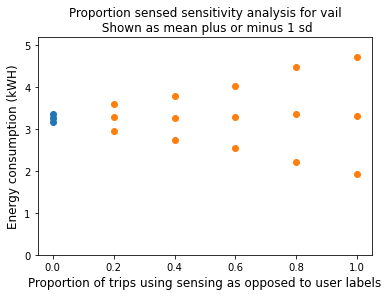

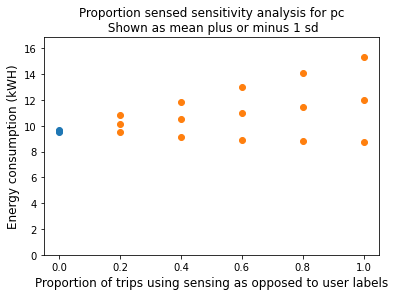

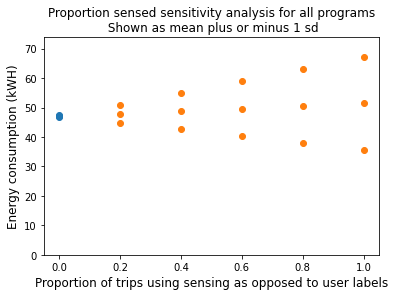

In [10]:
proportion_sensed = [0.2,0.4,0.6,0.8]
NMC = 100

# Plot for the cases of all user labels and all sensed.
def proportion_sensed_sensitivity_analysis(df, program):
    df = df.copy()
    mean_EC_sensed = sum(df['expected'])
    sd_EC_sensed = get_EC.get_totals_and_errors(df,os_EI_moments_map,unit_dist_MCS_df)['aggregate_sd']

    mean_EC_user_labeled, var_EC_user_labeled = sum(df['user_labeled']), sum(df['user_var'])

    x = [0]*3
    y = hf.get_interval(mean_EC_user_labeled, np.sqrt(var_EC_user_labeled))
    plt.scatter(x,y, c = 'tab:blue', marker= 'o')

    x = [1]*3
    y = hf.get_interval(mean_EC_sensed,sd_EC_sensed)
    plt.scatter(x,y, c = 'tab:orange', marker= 'o')

    plt.ylim([0,max(1.1*mean_EC_user_labeled,1.1*max(y))]) 
    plt.xlabel("Proportion of trips using sensing as opposed to user labels", fontsize = 12)
    plt.ylabel("Energy consumption (kWH)", fontsize= 12)
    plt.title(f"Proportion sensed sensitivity analysis for {program}\n Shown as mean plus or minus 1 sd")

    #plt.rcParams["figure.figsize"] = (6,8)

    summary_df_map = {}
    for ps in proportion_sensed:

        user_labeled_df,sensed_df  = skm.train_test_split(df, 
                                                    test_size = ps, # sensed
                                                    train_size = 1-ps,  # user_labeled
                                                    random_state= 6)
        
        mean_EC_sensed = sum(sensed_df['expected'])
        var_EC_sensed = get_EC.get_totals_and_errors(sensed_df,os_EI_moments_map,unit_dist_MCS_df)['aggregate_var']
        
        mean_EC_user_labeled, var_EC_user_labeled = sum(user_labeled_df['user_labeled']), sum(user_labeled_df['user_var'])

        estimated_EC = mean_EC_sensed + mean_EC_user_labeled
        estimated_sd = np.sqrt(var_EC_sensed + var_EC_user_labeled)

        x = [ps]*3
        y = hf.get_interval(estimated_EC,estimated_sd)
        plt.scatter(x,y, c = 'tab:orange', marker= 'o')

proportion_sensed_sensitivity_analysis(energy_consumption_df[energy_consumption_df.program == 'vail'], 'vail')

plt.figure()
proportion_sensed_sensitivity_analysis(energy_consumption_df[energy_consumption_df.program == 'pc'],'pc')

plt.figure()
proportion_sensed_sensitivity_analysis(energy_consumption_df,'all programs')

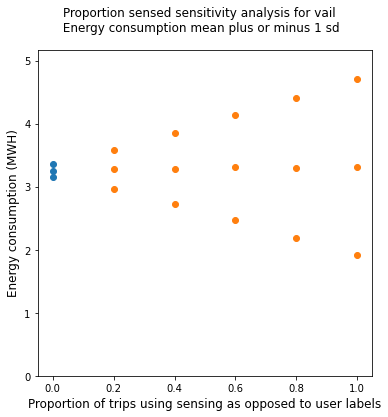

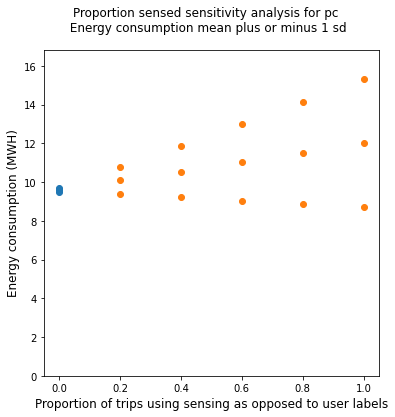

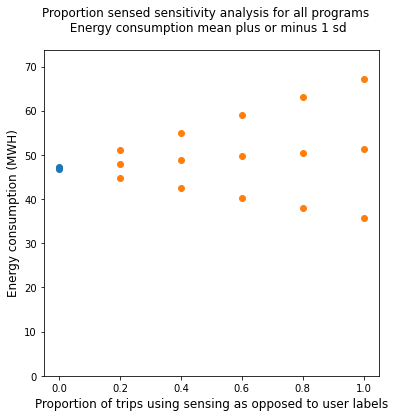

In [11]:
# Calculate the mean and sd for all user labeled and for all sensed

# Now calculate for various random splits of the data
def proportion_sensed_sensitivity_analysis_with_Monte_Carlo(df, program, print_info = True):
    '''
    Plots energy consumption +- 1 standard deviation for cases where some of the trip labels are sensed and others are user labels.
    Green dots are for user labeled energy consumption +- 1 sd.
    Runs a Monte Carlo simulation for each proportion of sensed trips.
        Randomly splits `df` repeatedly into trips that we will use sensed energy consumption for
        and trips that we will use user labeled energy consumption for.
        For each proportion sensed, the plots show the average across splits of the estimated mean and standard deviation.

    df: trips dataframe with both user labeled and expected energy consumptions.
    program: the program that df comes from.
    print_info: boolean to decide whether to print extra info besides the plots.

    Returns: 
        average_summaries: dictionary by proportion sensed of the average across splits of the estimated mean and standard deviation 
    '''
    df = df.copy()
    proportion_sensed = [0.2,0.4,0.6,0.8]
    NMC = 30

    mean_EC_sensed = sum(df['expected'])
    sd_EC_sensed = get_EC.get_totals_and_errors(df,os_EI_moments_map,unit_dist_MCS_df)['aggregate_sd']

    mean_EC_user_labeled, var_EC_user_labeled = sum(df['user_labeled']), sum(df['user_var'])
    sd_user_labeled = np.sqrt(var_EC_user_labeled)

    # Begin plotting.
    aggregate_EC_interval_sensed = hf.get_interval(mean_EC_sensed,sd_EC_sensed)
    aggregate_EC_interval_users = hf.get_interval(mean_EC_user_labeled,sd_user_labeled)

    fig,ax = plt.subplots()
    fig.set_figheight(6)

    if print_info == True:
        print(f"Prop = {0}: mean, sd: {mean_EC_user_labeled:.2f}, {sd_user_labeled:.2f}")
        print(f"Prop = {1}: mean, sd: {mean_EC_sensed:.2f}, {sd_EC_sensed:.2f}")

    # Plot the cases of fully user labeled and fully sensed.
    ax.scatter([0]*3,aggregate_EC_interval_users, c = 'tab:blue', marker= 'o')
    ax.scatter([1]*3,aggregate_EC_interval_sensed, c = 'tab:orange', marker= 'o')

    ax.set_ylim([0,max(1.1*mean_EC_user_labeled,1.1*max(aggregate_EC_interval_sensed))]) 
    ax.set_xlabel("Proportion of trips using sensing as opposed to user labels", fontsize = 12)
    ax.set_ylabel("Energy consumption (MWH)", fontsize= 12)
    fig.suptitle(f"Proportion sensed sensitivity analysis for {program}\n Energy consumption mean plus or minus 1 sd")

    summary_df_map = {}
    for ps in proportion_sensed:
        
        mean_aggregate_EC_list = []
        var_aggregate_EC_list = []
        error_aggregate_EC_list = []
        for j in range(0,NMC):
            rand_state = np.random.RandomState(1+j)

            #how did shankari split ?
            # Split the labeled trips into a user labeled dataframe and a sensed dataframe
            user_labeled,sensed_df  = skm.train_test_split(df, 
                                                        test_size = ps, # sensed
                                                        train_size = 1-ps,  # user_labeled
                                                        random_state= rand_state)
            mean_EC_sensed = sum(sensed_df['expected'])
            var_EC_sensed = get_EC.get_totals_and_errors(sensed_df,os_EI_moments_map,unit_dist_MCS_df)['aggregate_var']
            
            mean_EC_user_labeled, var_EC_user_labeled = sum(user_labeled['user_labeled']), sum(user_labeled['user_var'])

            # Get the total mean and variance for the current iteration and add it to a list.
            current_aggregate_EC = mean_EC_sensed + mean_EC_user_labeled
            mean_aggregate_EC_list.append(current_aggregate_EC)
            var_aggregate_EC_list.append(var_EC_sensed + var_EC_user_labeled)
            error_aggregate_EC_list.append(current_aggregate_EC - mean_EC_user_labeled)

            sd_aggregate_EC_list = np.sqrt(np.array(var_aggregate_EC_list))

        # After completing the Monte Carlo simulation, add a dataframe to a dictionary with proportion sensed as the key.
        summary_df_map[ps] = pd.DataFrame({"mean": mean_aggregate_EC_list, "sd": sd_aggregate_EC_list, 'error': error_aggregate_EC_list})

    average_summaries = {}
    for ps in proportion_sensed:
        average_across_splits_mean = np.mean(summary_df_map[ps]["mean"])
        average_across_splits_sd = np.mean(summary_df_map[ps]["sd"])
        average_summaries[ps] = {"mean": average_across_splits_mean, "sd": average_across_splits_sd}

    # Plot the cases with some trips sensed, other trips user labeled.
    for ps in proportion_sensed:
        summary = average_summaries[ps]

        if print_info == True:
            print(f"Prop = {ps}: mean, sd: {summary['mean']:.2f}, {summary['sd']:.2f}")
        x = [ps]*3
        y = hf.get_interval(summary["mean"],summary["sd"])
        ax.scatter(x,y, c = 'tab:orange', marker= 'o')



    return average_summaries

average_summaries_vail = proportion_sensed_sensitivity_analysis_with_Monte_Carlo(energy_consumption_df[energy_consumption_df.program == 'vail'], program = 'vail', print_info=False)
average_summaries_cc = proportion_sensed_sensitivity_analysis_with_Monte_Carlo(energy_consumption_df[energy_consumption_df.program == 'pc'], program = 'pc', print_info=False)
average_summaries_all = proportion_sensed_sensitivity_analysis_with_Monte_Carlo(energy_consumption_df, program = 'all programs', print_info=False)